In [1]:
#!nvidia-smi

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import random
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [2]:
configs = {
    "batch_size" : 48,
    "max_file_count" : 2179,
    "train_file" : 7,
    "validation_file" : 2,
    "test_file" : 10,
    "input_size" : 150,
    "output_size" : 1,
    "init_learning_rate" : 1e-2,
    "scheduler_factor": 0.6,
    "scheduler_patience": 5,
    "scheduler_min_lr": 5e-4,
    "epoch" : 7,
    "model_name" : "LSTM3",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
tickers = list(map(str.strip,open("tickers.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/48384 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21910 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/69615 [00:00<?, ?it/s]

In [4]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 1650
        self.batch_size = configs["batch_size"]
        self.h0 = torch.zeros((2,self.batch_size,self.hidden_size)).to(device)
        self.c0 = torch.zeros((2,self.batch_size,self.hidden_size)).to(device)
        self.layer1 = nn.LSTM(1,self.hidden_size,2,dropout=0.2,batch_first=True)
        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_size,512),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(512,256)
        self.layer4 = nn.Linear(256,1)

    def forward(self, input) :
        h1,(hn,cn) = self.layer1(input,(self.h0,self.c0))
        h2 = self.layer2(h1[:,-1,:])
        h3 = self.layer3(h2)
        output = self.layer4(h3)
        return output


In [5]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              32,703,000
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       845,312
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            131,328
├─Linear: 1-4                            257
Total params: 33,679,897
Trainable params: 33,679,897
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              32,703,000
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       845,312
|    └─ReLU: 2-2                         --
├─Linear: 1-3                            131,328
├─Linear: 1-4                            257
Total params: 33,679,897
Trainable params: 33,679,897
Non-trainable params: 0

In [6]:
loss_fn = torch.nn.L1Loss()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [8]:
train_losses = []
val_losses = []

train_avarage_losses = []
val_avarage_losses = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    train_avarage_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        val_avarage_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.21445363997583397
val loss :  0.017221680554365248


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.014318022292129518
val loss :  0.0171434547151684


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.014192861123269217
val loss :  0.017413591167464722


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.014077893718855367
val loss :  0.017634559810782473


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.014065877055852778
val loss :  0.017147902315564192


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.01407207306733148
val loss :  0.017458352601368046


  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

train loss :  0.014067997313326313
val loss :  0.01719579922664388


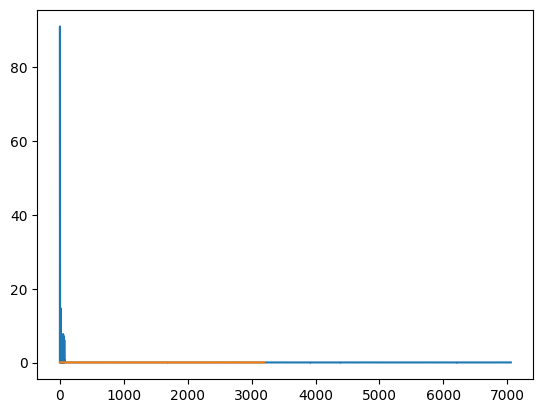

In [9]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [10]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [11]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/1451 [00:00<?, ?it/s]

0.01516277819229611


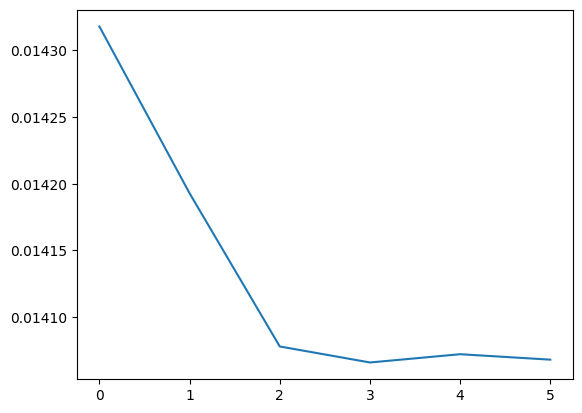

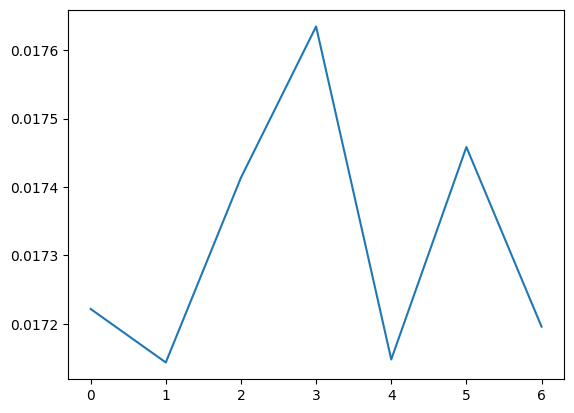

In [13]:
plt.plot(train_avarage_losses[1:])
plt.show()

plt.plot(val_avarage_losses)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

tensor([0.], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0020], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0012], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0044], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0564], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0014], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0040], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0095], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0073], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0333], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0054], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([-0.0100], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0063], device='cuda:0') tensor(-0.0010, device='cuda:0')
tensor([0.0119], device='cuda:0') tensor(-0.0010, device='cuda:

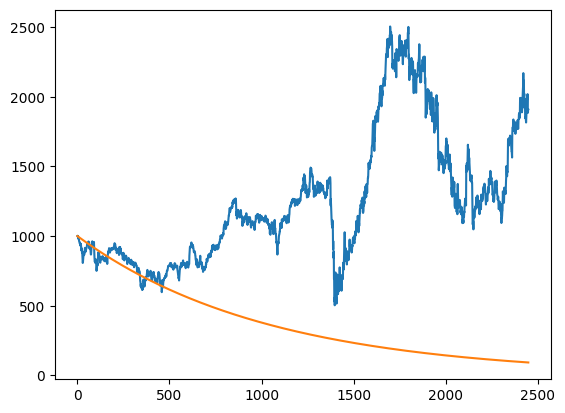

[0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704, 0.9990309825003704,

In [49]:
plot_dataset = StockDatasetLogReturn(["./data/ALLY.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
random.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(input[None,4,:,None])
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        print(close_price_input[0][0],output[0][0])
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real)
plt.plot(predict)
plt.show()
print(predict_output)